# [PIP-PRoS] Iterating parameters to improve speed of prediction

### Importing libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import pickle
import serial
import time
import sys
import glob

from params import *
from helpers import detect_ball, is_ball_inside_field, warp_point

file = open("../../assets/calibration/calibration.pkl",'rb')
cameraMatrix, dist = pickle.load(file)

### Original algorithm and parameters

In [2]:
# Original parameters
moving_average_window_size = 10
initializing_window = 5
discarted_values = 5

In [3]:
def predict_target(frame, kf, ball_position, xd_array, yd_array, x_robot_corner, max_width, max_height, y_preds, is_going_to_bounce, current_pred):
    top_left_corner = np.array([0, 0])
    bottom_right_corner = np.array([max_width, max_height])
    
    # Kalman predictions
    kf.correct(np.array(ball_position, dtype=np.float32))
    _, _, xd_pred, yd_pred = kf.predict()
    y_pred = current_pred
    field_height = (bottom_right_corner[1] - top_left_corner[1])
    if xd_pred and yd_pred:
        xd_array.append(xd_pred)
        yd_array.append(yd_pred)
    
    if len(xd_array) >= discarted_values + 1:
    
        if len(xd_array) > moving_average_window_size + initializing_window:
            # print(np.array(xd_array[-moving_average_window_size:]).flatten())
            xd = np.mean(xd_array[-moving_average_window_size:])
            yd = np.mean(yd_array[-moving_average_window_size:])
        elif len(xd_array) > initializing_window:
            # print(np.array(xd_array[initializing_window:]).flatten())
            xd = np.mean(xd_array[initializing_window:])
            yd = np.mean(yd_array[initializing_window:])
        else:
            xd = np.mean(xd_array)
            yd = np.mean(yd_array)
            
        slope = round(yd/xd, 2)
        if xd > 0 and (xd > 0.2 or abs(yd) > 0.2):
            initial_y_pred = slope*(x_robot_corner-ball_position[0]) + ball_position[1]
            is_going_to_bounce = not (bottom_right_corner[1] > initial_y_pred > top_left_corner[1])
            if initial_y_pred < top_left_corner[1]:
                overshoot_y = abs(top_left_corner[1] - initial_y_pred)
                number_of_refletions = np.ceil(overshoot_y / field_height).astype(int)
                if number_of_refletions <= max_number_of_refletions:
                    if (number_of_refletions % 2 == 1):
                        y_pred = top_left_corner[1] + (overshoot_y % field_height)
                    if (number_of_refletions % 2 == 0):
                        y_pred = bottom_right_corner[1] - overshoot_y % field_height
                    current_x = ball_position[0]
                    next_x = ball_position[0]
                    current_y = ball_position[1]
                    next_y = ball_position[1]
                    for n in range(1, number_of_refletions + 1):
                        if n % 2 == 1:
                            next_x = (top_left_corner[1] - current_y)/slope + current_x
                            next_y = top_left_corner[1]
                            cv2.line(frame, (int(current_x), int(current_y)), (int(next_x), top_left_corner[1]), predict_line_color, 1)     
                        if n % 2 == 0:
                            next_x = -(bottom_right_corner[1] - current_y)/slope + current_x
                            next_y = bottom_right_corner[1]
                            image = cv2.line(frame, (int(current_x), int(current_y)), (int(next_x), bottom_right_corner[1]), predict_line_color, 1)     
                        current_x = next_x
                        current_y = next_y
                    image = cv2.line(frame, (int(current_x), int(current_y)), (int(x_robot_corner), int(y_pred)), predict_line_color, 1)     
            
            elif initial_y_pred > bottom_right_corner[1]:
                overshoot_y = abs(initial_y_pred - bottom_right_corner[1])
                number_of_refletions = np.ceil(abs(overshoot_y / field_height)).astype(int)
                
                if number_of_refletions <= max_number_of_refletions:
                    if (number_of_refletions % 2 == 1):
                        y_pred = bottom_right_corner[1] - (overshoot_y % field_height)
                    if (number_of_refletions % 2 == 0):
                        y_pred = overshoot_y % field_height + top_left_corner[1]
                    current_x = ball_position[0]
                    next_x = ball_position[0]
                    current_y = ball_position[1]
                    next_y = ball_position[1]
                    for n in range(1, number_of_refletions + 1):
                        if n % 2 == 1:
                            next_x = (bottom_right_corner[1] - current_y)/slope + current_x
                            next_y = bottom_right_corner[1]
                            cv2.line(frame, (int(current_x), int(current_y)), (int(next_x), bottom_right_corner[1]), predict_line_color, 1)     
                        if n % 2 == 0:
                            next_x = -(top_left_corner[1] - current_y)/slope + current_x
                            next_y = top_left_corner[1]
                            image = cv2.line(frame, (int(current_x), int(current_y)), (int(next_x), top_left_corner[1]), predict_line_color, 1)     
                        current_x = next_x
                        current_y = next_y
                    image = cv2.line(frame, (int(current_x), int(current_y)), (int(x_robot_corner), int(y_pred)), predict_line_color, 1)     
            else:
                y_pred = initial_y_pred
                image = cv2.line(frame, (int(ball_position[0]), int(ball_position[1])), (int(x_robot_corner), int(y_pred)), predict_line_color, 1) 
        if xd < 0:
            xd_array = []
            yd_array = []
            y_preds = []
    
    return frame, y_pred, xd_pred, yd_pred, is_going_to_bounce



### Function that runs the program for a specified file and record the response

In [4]:
def test_prediction(filename, predict_function):
	cap = cv2.VideoCapture(filename)
	frame_ball_detection = 0
	frame_first_prediction = 0
	was_ball_detected = False
	frame = None
	if (cap.isOpened()== False): 
		print("Error opening video stream or file")
	else:
		for _ in range(2):
			ret, frame = cap.read()
		h, w, _ = frame.shape

	# Undistorting the frame
	newCameraMatrix, roi = cv2.getOptimalNewCameraMatrix(cameraMatrix, dist, (w,h), 1, (w,h))
	dst = cv2.undistort(frame, cameraMatrix, dist, None, newCameraMatrix)
	frame = dst[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]


	field_delimited = False

	# Transformation matrix for the homography
	M = None
	IM = None # The inverse of M
	max_width = None
	max_height = None

	# Relevant corners for the homography
	corners, ids = None, None
	top_left_corner = None
	bottom_right_corner = None
	top_right_corner = None
	bottom_left_corner = None

	# Configuring the ArUco detector
	aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
	parameters =  cv2.aruco.DetectorParameters()
	detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)

	while not field_delimited:
		succes, frame = cap.read()

		# Undistorting the frame from the camera
		# dst = cv2.undistort(frame, cameraMatrix, dist, None, newCameraMatrix)
		# frame = dst[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]
		output_frame = frame.copy()

		# First we make the image monochromatic
		gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

		# Then we detect the arucos
		corners, ids, rejectedImgPoints = detector.detectMarkers(gray)
		frame_markers = cv2.aruco.drawDetectedMarkers(frame.copy(), corners, ids)
		corners = np.array(corners, dtype=int)

		# We now check if the amount of detected ArUcos is the expected one
		# If it is not, the detection failed
		if len(corners) == 4:
			field_delimited = True
			# The top left corner is identified by the Aruco with ID = 0
			top_left_corner_id = np.where(ids == 0)[0]
			
			# The bottom right corner is identified by the Aruco with ID = 2
			bottom_right_corner_id = np.where(ids == 2)[0]

			# The bottom right corner is identified by the Aruco with ID = 3
			top_right_corner_id = np.where(ids == 4)[0]

			# The bottom right corner is identified by the Aruco with ID = 1
			bottom_left_corner_id = np.where(ids == 1)[0]

			top_left_corner = corners[top_left_corner_id][0][0][0]
			bottom_right_corner = corners[bottom_right_corner_id][0][0][0]
			top_right_corner = corners[top_right_corner_id][0][0][0]
			bottom_left_corner = corners[bottom_left_corner_id][0][0][0]

			width_top = np.hypot(
				top_left_corner[0] - top_right_corner[0], 
				top_left_corner[1] - top_right_corner[1])
			width_bottom = np.hypot(
				bottom_left_corner[0] - bottom_right_corner[0], 
				bottom_left_corner[1] - bottom_right_corner[1])
			max_width = max(int(width_top), int(width_bottom))
			
			height_left = np.hypot(
				top_left_corner[0] - bottom_left_corner[0], 
				top_left_corner[1] - bottom_left_corner[1])
			height_right = np.hypot(
				top_right_corner[0] - bottom_right_corner[0], 
				top_right_corner[1] - bottom_right_corner[1])
			max_height = max(int(height_left), int(height_right))

			input_pts = np.float32([top_left_corner, 
									bottom_left_corner, 
									bottom_right_corner, 
									top_right_corner])
			output_pts = np.float32([[0, 0],
									[0, max_height - 1],
									[max_width - 1, max_height - 1],
									[max_width - 1, 0]])

			# Compute the perspective transform M
			M = cv2.getPerspectiveTransform(input_pts,output_pts)
			_, IM = cv2.invert(M)
		
		output_frame = cv2.cvtColor(frame_markers, cv2.COLOR_BGR2RGB)

	# Variables to deal with the movement prediction
	is_going_to_bounce = False
	xd_array = []
	yd_array = []
	y_preds = []
	current_frame = 0
	y_pred = max_height/2
	x_robot_corner = max_width
	previous_y_robot = None

	# Kalman filter
	kf = cv2.KalmanFilter(4, 2)
	kf.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], np.float32)
	kf.transitionMatrix = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)

	while True:
		success, frame = cap.read()
		if not success: 
			break
		else:
			current_frame+=1
		# dst = cv2.undistort(frame, cameraMatrix, dist, None, newCameraMatrix)
		# frame = dst[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]
		output_frame = frame.copy()
		
		# Entering homography frame 
		h, w, _ = frame.shape
		homography = cv2.warpPerspective(frame,M,(max_width, max_height),flags=cv2.INTER_LINEAR)
		homography = cv2.line(homography, (hit_region, 0), (hit_region, max_height), color=(0, 255, 255), thickness=1)
		
		# Detect the ball
		is_ball_detected, _, _, x, y, radius = detect_ball(homography, homography)
		if is_ball_detected and not was_ball_detected:
			frame_ball_detection = current_frame
			was_ball_detected = True
		# Check if the ball is inside the field (close to the wall)
		if(is_going_to_bounce):
			ball_inside_field = is_ball_inside_field(x, y, 0, bounce_margin_size, max_width, max_height - bounce_margin_size)
		else:
			ball_inside_field = is_ball_inside_field(x, y, 0, 0, max_width, max_height)
		
		# The prediction only makes sense if the ball is present
		if (is_ball_detected and ball_inside_field):
			homography, y_pred, xd_pred, yd_pred, is_going_to_bounce = predict_function(homography, kf, [x, y], xd_array, yd_array, x_robot_corner, max_width, max_height, y_preds, is_going_to_bounce, y_pred)
			homography = cv2.arrowedLine(homography, (int(x), int(y)), (int(x+10*xd_pred), int(y+10*yd_pred)), (255, 0, 0), 2) 
		else:
			xd_array = []
			yd_array = []

		if y_preds != [] and (y_preds[-1] == max_height/2 and y_pred != max_height/2) and frame_first_prediction == 0:
			frame_first_prediction = current_frame
		
		y_preds.append(y_pred)
		y_robot = y_pred if len(y_preds) > 20 else np.mean(y_preds[-20:])
		# if xd_array == []:
		# 	y_robot = max_height/2
			
		if not previous_y_robot:
			previous_y_robot = y_robot
		else:
			if abs(y_robot - previous_y_robot) > 20:
				position_percentage = 1 - y_robot/max_height
				previous_y_robot = y_robot
				
		if (is_going_to_bounce):
			homography = cv2.line(homography, (0, bounce_margin_size),  (max_width, bounce_margin_size), color=(0, 0, 255), thickness=1)
			homography = cv2.line(homography, (0, max_height - bounce_margin_size), (max_width, max_height - bounce_margin_size), color=(0, 0, 255), thickness=1)
		
		# Returning to the original frame
		inversed_homography = cv2.warpPerspective(homography,IM,(w, h))
		output_frame[inversed_homography != 0] = 0
		output_frame = output_frame + inversed_homography
		output_frame = cv2.line(output_frame, top_left_corner, bottom_left_corner, color=(100, 0, 0), thickness=2)
		output_frame = cv2.line(output_frame, top_left_corner, top_right_corner, color=(100, 0, 0), thickness=2)
		output_frame = cv2.line(output_frame, bottom_right_corner, top_right_corner, color=(100, 0, 0), thickness=2)
		output_frame = cv2.line(output_frame, bottom_right_corner, bottom_left_corner, color=(100, 0, 0), thickness=2)
		
		x_robot, y_robot = warp_point(int(x_robot_corner), int(y_robot), IM)
		output_frame = cv2.rectangle(output_frame, (int(x_robot - 6), int(y_robot - 30)), (int(x_robot + 6), int(y_robot + 30)), color=(255, 255, 255), thickness=-1)
		
		# output_frame = cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB)

		cv2.imshow('output', output_frame)
		if cv2.waitKey(1) & 0xFF == ord('q'):
			break
	# When everything done, release the video capture object
	cap.release()
	
	# Closes all the frames
	cv2.destroyAllWindows()

	return len(y_preds), np.array(y_preds)/max_height, frame_ball_detection, frame_first_prediction

### Iterating through the discarted values 

Amount of discarted values at the beggining of the processing

In [6]:
file_list = glob.glob('./examples/*.avi')
discarted_values_vector = [0, 1, 2, 5, 7, 10]
for discarted_values in discarted_values_vector:
    for filename in file_list:
        n, y_preds, frame_ball_detected, frame_first_prediction = test_prediction(filename, predict_target)
        output = y_preds[frame_ball_detected:]
        np.savetxt(filename.split(".avi")[0]+f'_discarting{discarted_values}.txt', output)

KeyboardInterrupt: 

: 

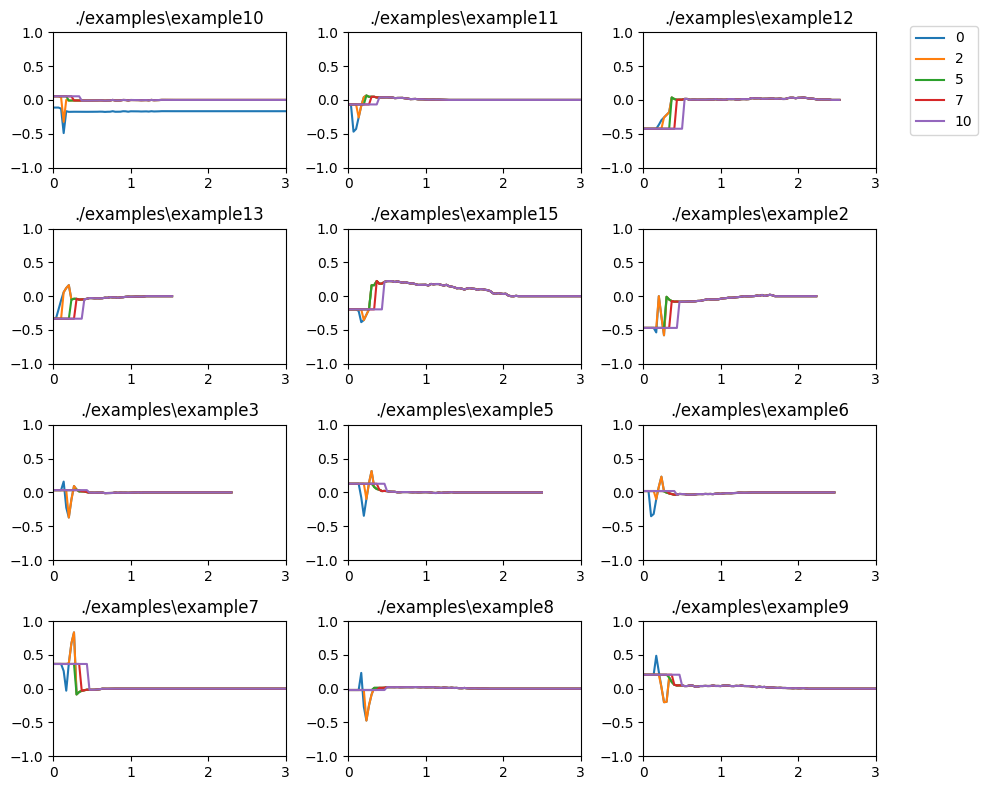

In [ ]:
file_list = glob.glob('./examples/*.avi')
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(9, 8))
discarted_values_vector = [0, 2, 5, 7, 10]
for i, filename in enumerate(file_list):
    name = filename.split(".avi")[0]
    for discarted_values in discarted_values_vector:
        values = np.loadtxt(name+f'_discarting{discarted_values}.txt')
        axes[int(i/3), i%3].plot(np.array((range(len(values))))/30, values - values[-1])
    axes[int(i/3), i%3].set_title(name)
    axes[int(i/3), i%3].set_ylim([-1, 1])
    axes[int(i/3), i%3].set_xlim([0, 3])
fig.legend(discarted_values_vector, bbox_to_anchor=(1.1,0.97))
plt.tight_layout()

Best value for this parameter seems to be **5**

### Testing heuristic for anticipating setpoint

In [ ]:
# Original parameters
moving_average_window_size = 10
initializing_window = 5
discarted_values = 5

In [ ]:
def predict_target2(frame, kf, ball_position, xd_array, yd_array, x_robot_corner, max_width, max_height, y_preds, is_going_to_bounce, current_pred):
    top_left_corner = np.array([0, 0])
    bottom_right_corner = np.array([max_width, max_height])
    
    # Kalman predictions
    kf.correct(np.array(ball_position, dtype=np.float32))
    _, _, xd_pred, yd_pred = kf.predict()
    y_pred = current_pred
    field_height = (bottom_right_corner[1] - top_left_corner[1])
    if xd_pred and yd_pred:
        xd_array.append(xd_pred)
        yd_array.append(yd_pred)
    
    if len(xd_array) >= discarted_values + 1:
    
        if len(xd_array) > moving_average_window_size + initializing_window:
            # print(np.array(xd_array[-moving_average_window_size:]).flatten())
            xd = np.mean(xd_array[-moving_average_window_size:])
            yd = np.mean(yd_array[-moving_average_window_size:])
        elif len(xd_array) > initializing_window:
            # print(np.array(xd_array[initializing_window:]).flatten())
            xd = np.mean(xd_array[initializing_window:])
            yd = np.mean(yd_array[initializing_window:])
        else:
            xd = np.mean(xd_array)
            yd = np.mean(yd_array)

        slope = round(yd/xd, 2)
        if xd > 0 and (xd > 0.2 or abs(yd) > 0.2):
            initial_y_pred = slope*(x_robot_corner-ball_position[0]) + ball_position[1]
            is_going_to_bounce = not (bottom_right_corner[1] > initial_y_pred > top_left_corner[1])
            if initial_y_pred < top_left_corner[1]:
                overshoot_y = abs(top_left_corner[1] - initial_y_pred)
                number_of_refletions = np.ceil(overshoot_y / field_height).astype(int)
                if number_of_refletions <= max_number_of_refletions:
                    if (number_of_refletions % 2 == 1):
                        y_pred = top_left_corner[1] + (overshoot_y % field_height)
                    if (number_of_refletions % 2 == 0):
                        y_pred = bottom_right_corner[1] - overshoot_y % field_height
                    current_x = ball_position[0]
                    next_x = ball_position[0]
                    current_y = ball_position[1]
                    next_y = ball_position[1]
                    for n in range(1, number_of_refletions + 1):
                        if n % 2 == 1:
                            next_x = (top_left_corner[1] - current_y)/slope + current_x
                            next_y = top_left_corner[1]
                            cv2.line(frame, (int(current_x), int(current_y)), (int(next_x), top_left_corner[1]), predict_line_color, 1)     
                        if n % 2 == 0:
                            next_x = -(bottom_right_corner[1] - current_y)/slope + current_x
                            next_y = bottom_right_corner[1]
                            image = cv2.line(frame, (int(current_x), int(current_y)), (int(next_x), bottom_right_corner[1]), predict_line_color, 1)     
                        current_x = next_x
                        current_y = next_y
                    image = cv2.line(frame, (int(current_x), int(current_y)), (int(x_robot_corner), int(y_pred)), predict_line_color, 1)     
            
            elif initial_y_pred > bottom_right_corner[1]:
                overshoot_y = abs(initial_y_pred - bottom_right_corner[1])
                number_of_refletions = np.ceil(abs(overshoot_y / field_height)).astype(int)
                
                if number_of_refletions <= max_number_of_refletions:
                    if (number_of_refletions % 2 == 1):
                        y_pred = bottom_right_corner[1] - (overshoot_y % field_height)
                    if (number_of_refletions % 2 == 0):
                        y_pred = overshoot_y % field_height + top_left_corner[1]
                    current_x = ball_position[0]
                    next_x = ball_position[0]
                    current_y = ball_position[1]
                    next_y = ball_position[1]
                    for n in range(1, number_of_refletions + 1):
                        if n % 2 == 1:
                            next_x = (bottom_right_corner[1] - current_y)/slope + current_x
                            next_y = bottom_right_corner[1]
                            cv2.line(frame, (int(current_x), int(current_y)), (int(next_x), bottom_right_corner[1]), predict_line_color, 1)     
                        if n % 2 == 0:
                            next_x = -(top_left_corner[1] - current_y)/slope + current_x
                            next_y = top_left_corner[1]
                            image = cv2.line(frame, (int(current_x), int(current_y)), (int(next_x), top_left_corner[1]), predict_line_color, 1)     
                        current_x = next_x
                        current_y = next_y
                    image = cv2.line(frame, (int(current_x), int(current_y)), (int(x_robot_corner), int(y_pred)), predict_line_color, 1)     
            else:
                y_pred = initial_y_pred
                image = cv2.line(frame, (int(ball_position[0]), int(ball_position[1])), (int(x_robot_corner), int(y_pred)), predict_line_color, 1) 
        if xd < 0:
            xd_array = []
            yd_array = []
            
    elif yd_array != []:
        # print(yd_pred)
        yd = np.mean(yd_array)
        print(yd)
        if yd < 0:
            y_pred = 1*max_height/4
        elif yd > 0:
            y_pred = 3*max_height/4
    
    return frame, y_pred, xd_pred, yd_pred, is_going_to_bounce



In [ ]:
file_list = glob.glob('./examples/*.avi')
for filename in file_list:
    n, y_preds, frame_ball_detected, frame_first_prediction = test_prediction(filename, predict_target2)
    output = y_preds[frame_ball_detected:]
    np.savetxt(filename.split(".avi")[0]+f'_heuristic.txt', output)

25.359474
22.356209
18.341364
14.801446
12.031945
25.717478
8.6772375
8.388193
23.142859
23.338827
20.421745
17.122578
14.415128
14.714287
15.597214
14.281056
12.56677
11.072474
14.089287
15.867548
15.033691
13.827324
12.675511
7.8571434
7.557143
4.085492
7.3022447
7.7831893
7.3341875
6.7316055
31.399067
31.6818
27.396057
22.899202
19.298666
26.644573
26.273605
22.362387
18.229145
14.889723
21.285715
21.084446
18.042374
14.756406
12.128341
21.07143
20.81905
17.912859
14.710262
12.128645
27.576532
25.549255
19.819094
14.360409
10.201006
37.928574
33.423832
25.490246
19.116692
14.600067
11.510541
30.929771
30.43069
25.726164
20.714514
16.617947


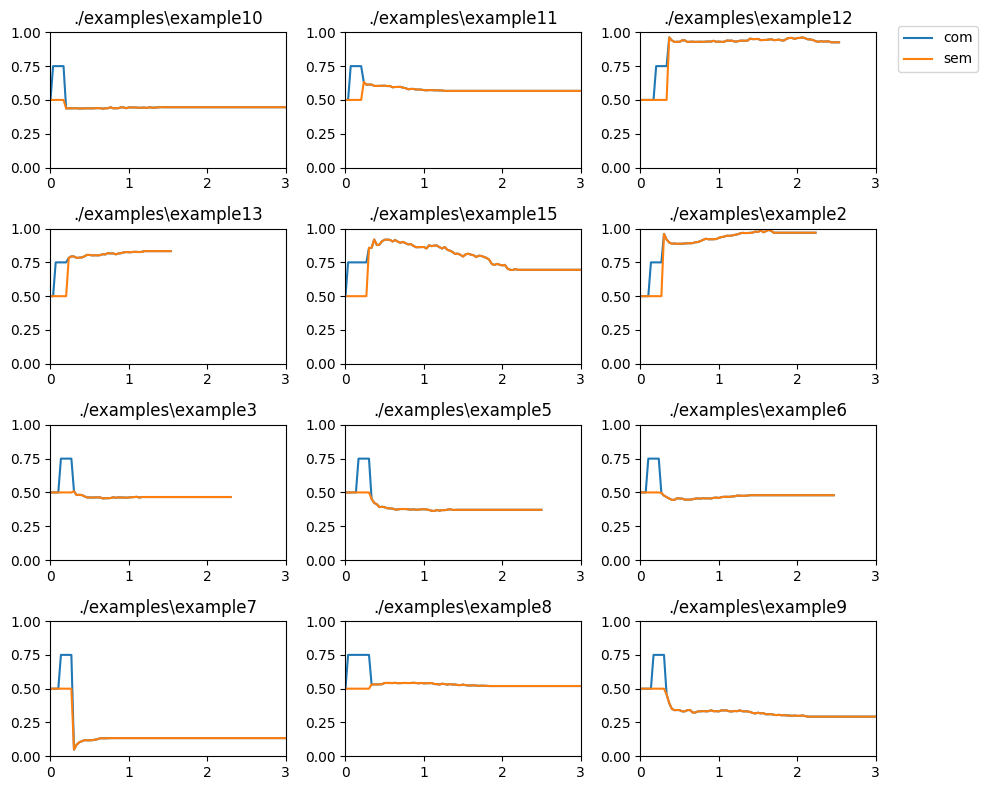

In [ ]:
file_list = glob.glob('./examples/*.avi')
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(9, 8))
discarted_values_vector = [0, 2, 5, 7, 10]
for i, filename in enumerate(file_list):
    name = filename.split(".avi")[0]
    values = np.loadtxt(name+f'_heuristic.txt')
    axes[int(i/3), i%3].plot(np.array((range(len(values))))/30, values)
    values = np.loadtxt(name+f'_discarting{5}.txt')
    axes[int(i/3), i%3].plot(np.array((range(len(values))))/30, values)
    axes[int(i/3), i%3].set_title(name)
    axes[int(i/3), i%3].set_ylim([0, 1])
    axes[int(i/3), i%3].set_xlim([0, 3])
fig.legend(['com', 'sem'], bbox_to_anchor=(1.1,0.97))
plt.tight_layout()